In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import powerlaw
from datetime import timedelta
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from tqdm import tqdm

# Check if you want to install these libraries
# !pip3 install torch
# !pip3 install torchvision


In [33]:
#!conda install --yes kaleido

In [34]:
file_path = "Fig/"  # Change this to your desired file path and format (e.g., .png, .jpg, .svg)
 
# Save the figure to the specified file path
network_name = "aragon"
window_size = 3
n = 3  # Replace with your desired value of n eigen values to use
threshold = pd.to_datetime('2018-03-01').date()
#read blockchain events from chartalist
url = "dataset/gt.txt"

selectedNetwork = pd.read_csv("dataset/network"+network_name+".txt", sep=' ', names=["from", "to", "date", "value"])
selectedNetwork['date'] = pd.to_datetime(selectedNetwork['date'], unit='s')

In [35]:
selectedNetwork

,from,to,date,value
0,16037,245854,2017-07-18 04:52:49,2843000000000000000
1,17,237348,2017-07-09 01:07:14,12340176380000000000
2,206254,194319,2018-01-18 00:21:30,595756626170000000000
3,256098,256097,2017-05-22 22:40:45,370000000000000000000
4,194319,184024,2018-02-01 04:03:38,2648440000000000000
...,...,...,...,...
130266,204756,204757,2018-01-14 00:26:09,60556464810000000000
130267,234906,248699,2017-07-15 23:42:22,50000000000000000000
130268,194319,251188,2017-06-25 07:33:26,568447662250000000000
130269,17,19526,2018-01-21 19:11:58,21107673650000000000


**Create the graph from transaction network**

In [36]:
aWindowGraph = nx.DiGraph()
# Populate graph with edges
for item in selectedNetwork.to_dict(orient="records"):
    aWindowGraph.add_edge(item["from"], item["to"], value=item["value"])
fit = powerlaw.Fit(list(dict(aWindowGraph.degree()).values()), estimate_discrete=False)

Calculating best minimal value for power law fit


In [37]:


# Read the file into a DataFrame
df_events = pd.read_csv(url, delimiter='\t')
df_events['date'] = pd.to_datetime(df_events['date'], format='%d-%m-%Y')

# Daily transaction network
Each data points in the phase base represent transaction networks for each day

In [38]:
selectedNetwork = pd.read_csv("dataset/network"+network_name+".txt", sep=' ', names=["from", "to", "date", "value"])
selectedNetwork['date'] = pd.to_datetime(selectedNetwork['date'], unit='s')
selectedNetwork = selectedNetwork.sort_values(by = 'date')
selectedNetwork['date'] = selectedNetwork['date'].dt.date
selectedNetwork

,from,to,date,value
49133,250733,248773,2017-05-17,135918900000000000000
110195,254519,248578,2017-05-17,4800000000000000000000
105736,51586,255124,2017-05-17,150000000000000000000
12305,38556,255135,2017-05-17,100000000000000000000
88428,254797,255142,2017-05-17,1470000000000000000000
...,...,...,...,...
114933,17,91951,2018-05-06,682400128610000000000
118737,194337,195499,2018-05-06,2304805430306600000
81326,195500,195501,2018-05-06,31413345939999997952
80973,195498,194319,2018-05-06,50000000000000000000


**Construct graph for each day and apply powerlaw test on each transaction graph and store it in CSV file**

In [39]:
currDate = selectedNetwork['date'].min()
aWindowGraph = nx.DiGraph()
score_list = []
column = ["score","#nodes","xmin","alpha","date"]
row_list = []
for index, row in selectedNetwork.iterrows():
    if(row['date'] != currDate ):
        row_df = []
        
        degrees = list(dict(aWindowGraph.degree()).values())
        fit = powerlaw.Fit(degrees)
        row_df.append(fit.distribution_compare('power_law', 'exponential')[0])
        row_df.append(aWindowGraph.number_of_nodes())
        row_df.append(fit.power_law.xmin)
        row_df.append(fit.power_law.alpha)
        row_df.append(currDate)
        
        currDate = row['date']
        
        row_list.append(row_df)
        aWindowGraph = nx.DiGraph()
    else:
        aWindowGraph.add_edge(row["from"], row["to"], value=row["value"])
df_power_law = pd.DataFrame(row_list,columns= column)    
 

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [40]:
df_power_law['date'] = pd.to_datetime(df_power_law['date'])
df_power_law['date'] = df_power_law['date'].dt.date

event_days_data = df_power_law[df_power_law['date'] <= threshold]
testNetwork = df_power_law[df_power_law['date'] > threshold]

**Draw diagram to illustrate the trajectory with data points in steady period in green**

In [41]:
fig = go.Figure()

# Add a line trace
fig.add_trace(go.Scatter(x=event_days_data['#nodes'], y=event_days_data['alpha'], mode='lines', name='Line', line=dict(width=1, color='black')))
fig.add_trace(go.Scatter(x=event_days_data['#nodes'], y=event_days_data['alpha'], mode='markers', name='Scatter', line=dict(color='black')))
fig.add_trace(go.Scatter(x=testNetwork['#nodes'], y=testNetwork['alpha'], mode='lines', name='Line',line=dict(width=1,color='red')))
fig.add_trace(go.Scatter(x=testNetwork['#nodes'], y=testNetwork['alpha'], mode='markers', name='Scatter',line=dict(color='red')))

# Customize the layout
fig.update_layout(
    title=dict(
        text=network_name+'\'s Trajectory',  # Set the title here
        x=0.5,  # Center the title horizontally (0.5 means middle)
        y=0.95,  # Adjust the vertical position as needed (0.95 is near the top)
    ),
    xaxis=dict(title='#nodes'),
    yaxis=dict(title='alpha'),
    paper_bgcolor='white',  # Set the background color to white
    plot_bgcolor='white',   # Set the plot area background color to white
    width=1000
    
)

fig.update_xaxes(linecolor='black')
fig.update_yaxes(linecolor='black')
fig.update_traces(showlegend=False)
# Show the plot
fig.show()
fig.write_image(file_path+"alpha"+network_name+"_"+str(window_size)+".png")


# Sliding window
Each data points in the phase base represent transaction networks for windows of 7 days

In [42]:
file_path = file_path + network_name + "/" + str(window_size) + "/"


threshold = pd.to_datetime('2018-03-01').date()
selectedNetwork = pd.read_csv("dataset/network"+network_name+".txt", sep=' ', names=["from", "to", "date", "value"])
selectedNetwork['date'] = pd.to_datetime(selectedNetwork['date'], unit='s')

In [43]:
selectedNetwork

,from,to,date,value
0,16037,245854,2017-07-18 04:52:49,2843000000000000000
1,17,237348,2017-07-09 01:07:14,12340176380000000000
2,206254,194319,2018-01-18 00:21:30,595756626170000000000
3,256098,256097,2017-05-22 22:40:45,370000000000000000000
4,194319,184024,2018-02-01 04:03:38,2648440000000000000
...,...,...,...,...
130266,204756,204757,2018-01-14 00:26:09,60556464810000000000
130267,234906,248699,2017-07-15 23:42:22,50000000000000000000
130268,194319,251188,2017-06-25 07:33:26,568447662250000000000
130269,17,19526,2018-01-21 19:11:58,21107673650000000000


**Apply sliding window algorithm and apply powerlaw test on each window and store to dataframe**

In [44]:
def sliding_window_dates(start_date, end_date, window_size=7):
    # Initialize the sliding window
    
    window_end = start_date   # Initial window size is 6 days
    
    
    # Slide the window through the date interval
    while window_end <= end_date:
        window_start = window_end - timedelta(days=(window_size-1))
        if(window_start >= start_date):
            yield (window_start, window_end)
        
        
        # Slide the window by one day
       
        window_end += timedelta(days=1)


start_date = selectedNetwork['date'].min()
end_date = selectedNetwork['date'].max()

 

In [45]:
start_date = selectedNetwork['date'].min()
end_date = selectedNetwork['date'].max()

score_list = []

rnn_column_names = [f"e{i}" for i in range(n)]
column = ["#nodes","window_start","window_end"] + rnn_column_names
row_list = []

dates = sliding_window_dates(start_date, end_date,window_size)


for window_start, window_end in dates:
    selectedNetworkInTimeFrame = selectedNetwork[
        (selectedNetwork['date'] >= window_start) & (selectedNetwork['date'] <= window_end)]
    aWindowGraph = nx.DiGraph()

    for index, row in selectedNetworkInTimeFrame.iterrows():
        aWindowGraph.add_edge(row["from"], row["to"], value=row["value"])
    row_df = []

    adjacency_matrix = nx.to_numpy_array(aWindowGraph)

    # Calculate the eigenvalues
    eigenvalues = np.linalg.eigvals(adjacency_matrix)

    # Sort the eigenvalues in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]

    # Extract the largest two eigenvalues
    largest_eigenvalues = sorted_eigenvalues[:3]
    
    if(len(largest_eigenvalues) >= 3):
        row_df.append(aWindowGraph.number_of_nodes())
        row_df.append(window_start)
        row_df.append(window_end)
        for i in range(0,n):
            row_df.append(largest_eigenvalues[i].real)
        
        row_list.append(row_df)
        

df_sliding = pd.DataFrame(row_list,columns= column)  


[2068, Timestamp('2017-05-17 18:36:22'), Timestamp('2017-05-19 18:36:22'), 2.7778710697861513, 1.0000000000000013, 1.0000000000000013]
[1021, Timestamp('2017-05-18 18:36:22'), Timestamp('2017-05-20 18:36:22'), 1.7963219032594415, 1.0, 1.0]
[757, Timestamp('2017-05-19 18:36:22'), Timestamp('2017-05-21 18:36:22'), 1.0, 1.0, 1.0]
[567, Timestamp('2017-05-20 18:36:22'), Timestamp('2017-05-22 18:36:22'), 1.2599210498948752, 0.0, 0.0]
[585, Timestamp('2017-05-21 18:36:22'), Timestamp('2017-05-23 18:36:22'), 1.259921049894873, 1.0, 0.0]
[859, Timestamp('2017-05-22 18:36:22'), Timestamp('2017-05-24 18:36:22'), 1.4422495703074096, 1.0, 9.41842561629421e-17]
[932, Timestamp('2017-05-23 18:36:22'), Timestamp('2017-05-25 18:36:22'), 1.5213797068045678, 1.0, 0.0]
[662, Timestamp('2017-05-24 18:36:22'), Timestamp('2017-05-26 18:36:22'), 1.0, 1.0, 0.0]
[565, Timestamp('2017-05-25 18:36:22'), Timestamp('2017-05-27 18:36:22'), 1.0, 1.0, 1.0]
[451, Timestamp('2017-05-26 18:36:22'), Timestamp('2017-05-28

In [46]:
dates

<generator object sliding_window_dates at 0x10ca56840>

In [47]:

df_sliding['window_start'] = pd.to_datetime(df_sliding['window_start'], format='%Y-%m-%d')
df_sliding['window_end'] = pd.to_datetime(df_sliding['window_end'], format='%Y-%m-%d')
# Convert 'date' in df_events to datetime
df_events['date'] = pd.to_datetime(df_events['date'], format='%Y-%m-%d')
df_events

,date,event
0,2016-02-10,Bitcoin Classic is released
1,2016-02-23,Bitcoin Core version 0.12.0 is released
2,2016-06-11,Bitcoin market capitalization reaches US$ 10 b...
3,2016-04-15,Bitcoin Core version 0.12.1 is released
4,2016-08-02,The Bitfinex hack is first announced
...,...,...
67,2019-05-02,Bitcoin Core version 0.18.0 is released
68,2019-08-09,Bitcoin Core version 0.18.1 is released
69,2019-10-18,The 18 millionth bitcoin is mined
70,2019-10-24,Bitcoin Core version 0.19.0.1 is released


In [48]:

def experiment(network_name,window_size, n):
    result = [f"e{i}" for i in range(n)]
    column_names = ["#nodes","window_start","window_end","nodes","alpha","xmin"]+result
    # Change this to your desired file path and format (e.g., .png, .jpg, .svg)
    
    selectedNetwork = pd.read_csv("dataset/network"+network_name+".txt", sep=' ', names=["from", "to", "date", "value"])
    selectedNetwork['date'] = pd.to_datetime(selectedNetwork['date'], unit='s')
    selectedNetwork = selectedNetwork.sort_values(by = 'date')
    selectedNetwork['date'] = selectedNetwork['date'].dt.date
    
    start_date = selectedNetwork['date'].min()
    end_date = selectedNetwork['date'].max()
      
    row_list = []

    for window_start, window_end in sliding_window_dates(start_date, end_date,window_size):
        selectedNetworkInTimeFrame = selectedNetwork[
            (selectedNetwork['date'] >= window_start) & (selectedNetwork['date'] <= window_end)]
        aWindowGraph = nx.DiGraph()

        for index, row in selectedNetworkInTimeFrame.iterrows():
            aWindowGraph.add_edge(row["from"], row["to"], value=row["value"])
        row_df = []
        degrees = list(dict(aWindowGraph.degree()).values())
        fit = powerlaw.Fit(degrees,verbose=False)
        
        adjacency_matrix = nx.to_numpy_array(aWindowGraph)
        # Calculate the eigenvalues
        eigenvalues = np.linalg.eigvals(adjacency_matrix)
    
        # Sort the eigenvalues in descending order
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    
        # Extract the largest two eigenvalues
        largest_eigenvalues = sorted_eigenvalues[:n]
       
        if(len(largest_eigenvalues) >= n):
                row_df.append(aWindowGraph.number_of_nodes())
                row_df.append(window_start)
                row_df.append(window_end)
                row_df.append(aWindowGraph.number_of_nodes())
                row_df.append(fit.power_law.alpha)
                row_df.append(fit.power_law.xmin)
                for i in range(0,n):
                    row_df.append(largest_eigenvalues[i].real)
            
                row_list.append(row_df)   
    
    
    return pd.DataFrame(row_list,columns= column_names) 
    

In [49]:
df = experiment(network_name,7, 3)

In [50]:
print(df)
 

     #nodes window_start  window_end  nodes      alpha  xmin        e0  \
0      3145   2017-05-17  2017-05-23   3145   4.586912   3.0  3.404611   
1      2775   2017-05-18  2017-05-24   2775   9.191478   2.0  2.936838   
2      2318   2017-05-19  2017-05-25   2318   8.788327   2.0  2.633650   
3      2208   2017-05-20  2017-05-26   2208   8.589375   2.0  2.373650   
4      1984   2017-05-21  2017-05-27   1984   9.250640   2.0  2.086745   
..      ...          ...         ...    ...        ...   ...       ...   
344     856   2018-04-26  2018-05-02    856  12.136441   2.0  2.802039   
345     837   2018-04-27  2018-05-03    837  13.192193   2.0  2.668402   
346     855   2018-04-28  2018-05-04    855  13.962887   2.0  2.884499   
347     852   2018-04-29  2018-05-05    852  14.571401   2.0  3.036589   
348     762   2018-04-30  2018-05-06    762  14.310812   2.0  2.924018   

               e1            e2  
0    1.000000e+00  1.000000e+00  
1    1.000000e+00  1.000000e+00  
2    1.00

In [51]:
price_file = "dataset/price_dataset/" + network_name + "_price.csv"
price = pd.read_csv(price_file, sep=',', header=0)
price['date'] = pd.to_datetime(price['date'], format='%Y-%m-%d')
price['date'] = pd.to_datetime(price['date']).dt.date
# Convert the 'window_start' column in 'df_sliding' to datetime with date part
df_sliding['window_start'] = pd.to_datetime(df_sliding['window_start']).dt.date

# Now, both 'date' columns have the same datetime data type
merged_df = pd.merge(price, df_sliding, left_on='date', right_on='window_start', how='inner')

In [52]:
merged_df

,Unnamed: 0,open,high,low,close,volume,marketCap,date,#nodes,window_start,window_end,e0,e1,e2
0,0,1.48563,1.55702,1.41713,1.52438,2745280,0.000000e+00,2017-05-18,1021,2017-05-18,2017-05-20 18:36:22,1.796322,1.000000e+00,1.000000e+00
1,1,1.49932,1.55898,1.28817,1.33077,1655390,3.689782e+07,2017-05-19,757,2017-05-19,2017-05-21 18:36:22,1.000000,1.000000e+00,1.000000e+00
2,2,1.32789,1.47018,1.30107,1.43403,1272560,4.819082e+07,2017-05-20,567,2017-05-20,2017-05-22 18:36:22,1.259921,0.000000e+00,0.000000e+00
3,3,1.45229,1.49973,1.32560,1.41018,1152680,4.738933e+07,2017-05-21,585,2017-05-21,2017-05-23 18:36:22,1.259921,1.000000e+00,0.000000e+00
4,4,1.40033,1.61170,1.20274,1.53604,1358470,5.161888e+07,2017-05-22,859,2017-05-22,2017-05-24 18:36:22,1.442250,1.000000e+00,9.418426e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,346,4.35008,4.49983,4.19932,4.46659,811571,1.177818e+08,2018-04-29,230,2018-04-29,2018-05-01 18:36:22,1.442250,5.551115e-17,5.551115e-17
347,347,4.48640,4.56640,4.26756,4.48674,769705,1.183131e+08,2018-04-30,216,2018-04-30,2018-05-02 18:36:22,0.000000,0.000000e+00,0.000000e+00
348,348,4.49185,4.49996,4.16600,4.36430,425023,1.150844e+08,2018-05-01,260,2018-05-01,2018-05-03 18:36:22,1.000000,0.000000e+00,0.000000e+00
349,349,4.35751,4.56330,4.31095,4.55272,443267,1.200530e+08,2018-05-02,308,2018-05-02,2018-05-04 18:36:22,1.817121,8.941458e-09,8.941458e-09


In [53]:
# Select the relevant columns
rnn_column_names = [f"e{i}" for i in range(n)]
rnn_column_names.append("open")
items_to_fetch = rnn_column_names + ['close']
data = merged_df[items_to_fetch].copy()
 
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
# Shift the 'close' column by window_size
 
data[:, -1] = np.roll(data[:, -1], -window_size)

# Split the data into features (X) and labels (y)
X = data[:, :-1]  # Features (eigen values)
y = data[:, -1]   # Labels (close)

 
# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X = X.view(-1, 1, len(rnn_column_names))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [54]:
# Define the RNN model using PyTorch
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return out

# Initialize the RNN model
input_size = len(rnn_column_names)
hidden_size = 64
num_layers = 3

model = SimpleRNNModel(input_size, hidden_size, num_layers)



In [55]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_losses = []
# Training loop
epochs = 50
for epoch in range(epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    
    test_losses.append(loss.item())

    test_loss = 0.0  # Initialize test loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    mse = mean_squared_error(y_test, test_outputs)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_outputs)
    r2 = r2_score(y_test, test_outputs)
    explained_variance = explained_variance_score(y_test, test_outputs)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Test Loss: {test_loss.item()}, Test MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}, Explained Variance: {explained_variance}')
     


 


Epoch [1/50], Loss: 0.17587554454803467, Test Loss: 0.13528074324131012, Test MSE: 0.1326984316110611, RMSE: 0.3642779588699341, MAE: 0.2952500879764557, R2: -1.7616978642292858, Explained Variance: 0.05252474546432495
Epoch [2/50], Loss: 0.13300104439258575, Test Loss: 0.10144895315170288, Test MSE: 0.09855557978153229, RMSE: 0.31393563747406006, MAE: 0.23162350058555603, R2: -1.0511225709461165, Explained Variance: 0.05843245983123779
Epoch [3/50], Loss: 0.09806063771247864, Test Loss: 0.07563936710357666, Test MSE: 0.07241654396057129, RMSE: 0.2691032290458679, MAE: 0.18152521550655365, R2: -0.5071212495105857, Explained Variance: 0.0644369125366211
Epoch [4/50], Loss: 0.07115469127893448, Test Loss: 0.0582016222178936, Test MSE: 0.054632026702165604, RMSE: 0.23373495042324066, MAE: 0.1600276380777359, R2: -0.13699276968039964, Explained Variance: 0.07046127319335938
Epoch [5/50], Loss: 0.052642080932855606, Test Loss: 0.04948722943663597, Test MSE: 0.04556134715676308, RMSE: 0.2134

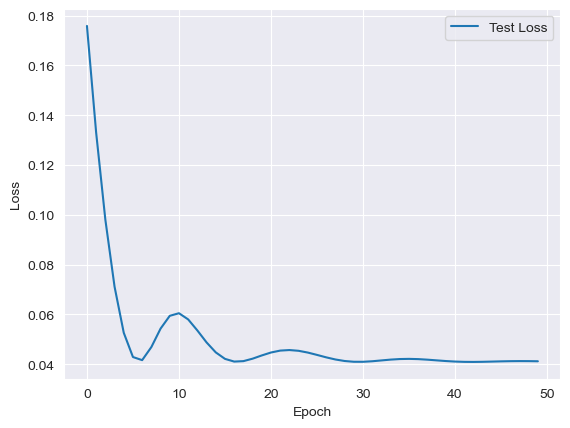

In [56]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

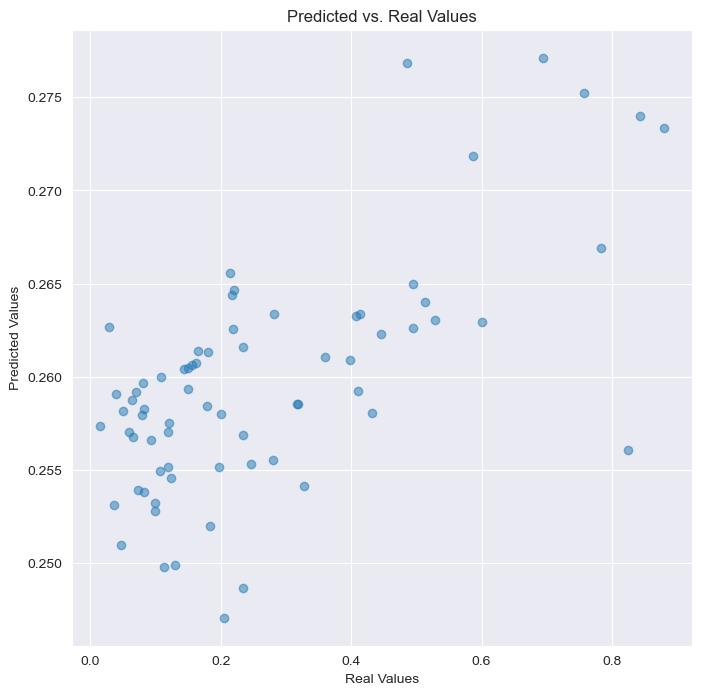

In [57]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_outputs, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Real Values')
plt.show()